# Portfolio Construction and Analysis -- Efficient Frontier
## Objectives
1. Draw the efficient Frontier for a given set of returns and volatility

In [148]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sys
sys.path.insert(0, 'python_files')
import functions_1 as fnc
import edhec_risk_kit_127 as erk

r = fnc.local_returns_data().dropna()
rm = fnc.change_timeframe(r.dropna(), 'M')
er = fnc.annualize_returns(rm, 12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
cov = r.cov()

In [150]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or N x 1 matrix and returns are a numpy array or N x 1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

In order to find the optimal weights we need a function that will minimize the volatility for a given level of return.

In [151]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov, weight_constraints = 1):
    """
    Returns the optimal weights that acieve the target return.

    Inputs-->
    target_return: desired level of return
    er: expected returns for each asset in the portfolio
    cov: covariance matrix for the given assets
    weight_constraints: default(1) weight constraint. Anythng above means leveraging
    """
    n = er.shape[0] #number of assets
    init_guess = np.repeat(1/n, n)
    bounds = ((0, weight_constraints),) * n
    #construct the constraints
    weights_sum_to_contraint = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - weight_constraints
    }
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_contraint,return_is_target),
                       bounds=bounds)
    return weights.x


### Optimal Weights

In [152]:
def optimal_weights(n_points, er, cov, weight_constraints=1):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max()*weight_constraints, n_points)
    weights = [minimize_vol(target_return, er, cov, weight_constraints) for target_return in target_rs]
    return weights

## Efficient Frontier

In [166]:
def msr(riskfree_rate, er, cov, weight_constraints=1):
    """
    Returns a dataframe containing the weights of the maximum sharpe ratio portfolio, portfolio returns, volatility, and sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, weight_constraints),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_constraint = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - weight_constraints
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_constraint,),
                       bounds=bounds)
    df = pd.DataFrame({'Weights':[weights.x],
                       'Portfolio Return': portfolio_return(weights.x, er),
                       'Portfolio Volatility': portfolio_vol(weights.x, cov),
                       'Sharpe Ratio': (portfolio_return(weights.x, er)-riskfree_rate)/portfolio_vol(weights.x, cov)})
    return df


In [167]:
def gmv(cov, er=None, riskfree_rate=0, weight_constraints=1):
    """
    Returns a dataframe or array containing the weights of the minimum variance portfolio and it's returns, volatility and sharpe ratio based on the expected returns if given
    
    Inputs-->
    cov: covariance matrix
    er: default(None), expected returns to calculate the performance of the portfolio
    riskfree_rate: default(0), used in the calculation of sharpe ratio
    """
    n = cov.shape[0]
    weights = msr(0, np.repeat(1, n), cov, weight_constraints).loc[0, 'Weights']
    if er is None:
        return weights
    else:
        df = pd.DataFrame({'Weights':[weights],
                       'Portfolio Return': portfolio_return(weights, er),
                       'Portfolio Volatility': portfolio_vol(weights, cov),
                       'Sharpe Ratio': (portfolio_return(weights, er)-riskfree_rate)/portfolio_vol(weights, cov)})
        return df

In [168]:
def plot_ef(n_points, er, cov, dataframe=False, weight_constraints=1, style='.-', legend=False, show_msr=False, riskfree_rate=0, show_ew=False, show_gmv=False, figsize=(12,6)):
    """
    Plots or returns a dataframe if applied of the efficient frontier for the given expected returns and covariance matrix.

    Inputs-->
    n_points: number of points on the efficient frontier
    er: expected returns
    cov: covariance matrix of the given returns
    dataframe: default(False), returns a dataframe except a plot
    weight_constraint: default(1), leverage factor
    style: default('.-'), style of the efficient frontier line
    legend: default(False)
    show_msr: default(False), shows the portfolio with maximum sharpe ratio
    riskfree_rate: default(0), riskfree rate to be used in the calculation of sharpe ratio
    show_ew: default(False), show the equal weighted portfolio
    show_gmv: default(False), show the global minimum variance portfolio
    figsize: default((12,6)), size of the plot

    """
    weights = optimal_weights(n_points, er, cov, weight_constraints)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    sharpe_ratio = [(ret - riskfree_rate)/vol for ret, vol in zip(rets, vols)]
    if dataframe:
        df = pd.DataFrame({
            "Weights": weights,
            "Returns": rets, 
            "Volatility": vols,
            "Sharpe Ratio": sharpe_ratio
            })
        return df
    else:
        ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
        })
        ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, figsize=figsize)
        if show_msr:
            ax.set_xlim(left = 0)
            w_msr = msr(riskfree_rate, er, cov, weight_constraints).loc[0, 'Weights']
            r_msr = portfolio_return(w_msr, er)
            vol_msr = portfolio_vol(w_msr, cov)
            #add CML
            cml_x = [0, vol_msr]
            cml_y = [riskfree_rate, r_msr]
            ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
        if show_ew:
            n = er.shape[0]
            w_ew = np.repeat(1/n, n)
            r_ew = portfolio_return(w_ew, er)
            vol_ew = portfolio_vol(w_ew, cov)
            ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
        if show_gmv:
            w_gmv = gmv(cov, weight_constraints=weight_constraints)
            r_gmv = portfolio_return(w_gmv, er)
            vol_gmv = portfolio_vol(w_gmv, cov)
            ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        return ax


Let's plot an efficeint frontier for the expected returns that we obtained in the last notebooks and their covariance on daily data

<Axes: xlabel='Volatility'>

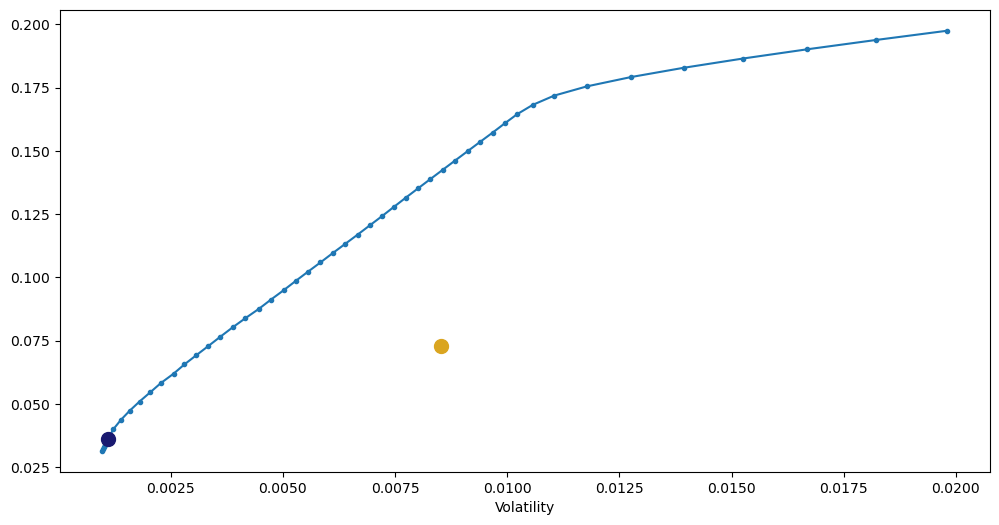

In [169]:
plot_ef(50, er, cov, show_gmv=True, show_ew=True, weight_constraints=2)

In [170]:
a = plot_ef(50, er, cov, dataframe=True)
a.head()

,Weights,Returns,Volatility,Sharpe Ratio
0,"[0.9999999799302114, 2.0069788844723213e-08, 0...",0.017976,0.000552,32.580838
1,"[0.971342565373896, 4.255493527005605e-18, 0.0...",0.019625,0.000596,32.902768
2,"[0.9451522174984943, 0.0, 0.0, 7.5894152073985...",0.021273,0.000667,31.914274
3,"[0.9187301059920776, 0.0, 0.0, 3.4694469519536...",0.022922,0.000751,30.524539
4,"[0.8925271710064983, 0.0, 0.0, 0.0, 0.00476733...",0.024570,0.000847,29.009029


<Axes: xlabel='Volatility'>

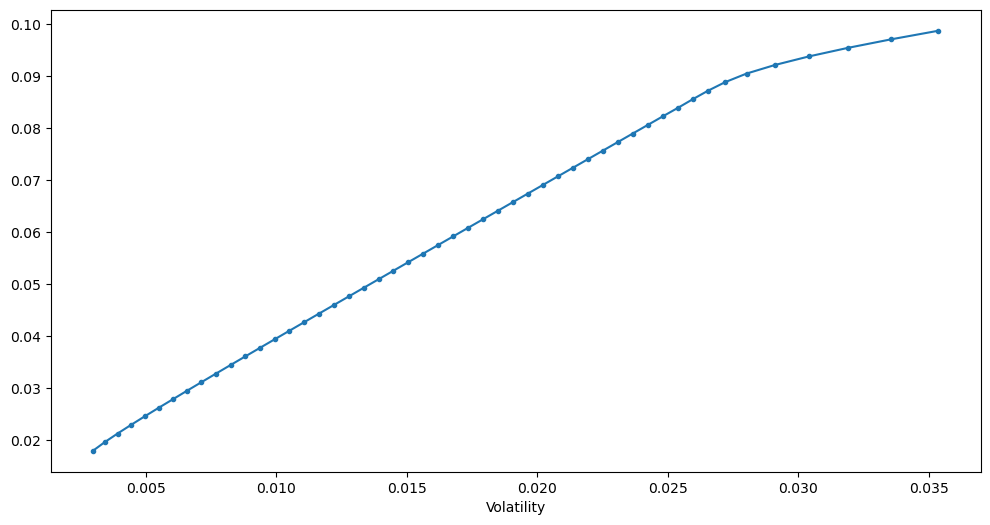

In [179]:
plot_ef(50, er, rm.cov())